### Tensorflow Implementation

- MNIST Dataset
- Sequential Model
- Monitoring training as well as test (Validation)
- L2 Regularization
- Dropouts
- Batch Norm
- Early Stopping

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

In [2]:
### -----------------
### Global parameters
### -----------------
RANDOM_STATE = 24
np.random.seed(RANDOM_STATE)           # Set random seed for reproducible results
tf.random.set_seed(RANDOM_STATE)

TEST_SIZE = 0.2
ALPHA = 0.001
WEIGHT_DECAY = 0.001     # For regularization
EPOCHS = 30
BATCH_SIZE = 32

PATIENCE = 20          # for early stopping
LR_PATIENCE = 10
LR_FACTOR = 0.1       # by what factor we are reducing the lr

# parameters for matplotlib
params = {'legend.fontsize': 'medium',
          'figure.figsize' : (15,6),
          'axes.labelsize': 'large',
          'axes.titlesize':'large',
          'xtick.labelsize':'medium',
          'ytick.labelsize':'medium'
          }

CMAP = 'coolwarm' # plt.cm.Spectral

plt.rcParams.update(params)

### BASICS

In [3]:
# # for, Physical device :

# physical_device = tf.config.list_physical_devices('GPU')
# if len(physical_device) > 0:
#   tf.config.experimental.set_memory_growth(physical_device[0], True)          code this only when you are working on local machine and using GPU and you don't want tensorflow to occupy the whole GPU at once and give access to other fn to utilise GPU

In [4]:
# Location of the directories :

inpDir = os.path.join('..','..','input')
outDir = os.path.join('..','output')
subDir = 'ionosphere'
modelDir = os.path.join('..','models')

In [5]:
# whenever we are working using inpDir and subDir on out machine, then

# data_df = pd.read_csv(os.path.join(inpDir, subDir, 'ionosphere.data), header=None)
# data_df.head()

In [6]:
data_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Datasets/weatherHistory.csv')

data_df.head()

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


In [7]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96453 entries, 0 to 96452
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Formatted Date            96453 non-null  object 
 1   Summary                   96453 non-null  object 
 2   Precip Type               95936 non-null  object 
 3   Temperature (C)           96453 non-null  float64
 4   Apparent Temperature (C)  96453 non-null  float64
 5   Humidity                  96453 non-null  float64
 6   Wind Speed (km/h)         96453 non-null  float64
 7   Wind Bearing (degrees)    96453 non-null  float64
 8   Visibility (km)           96453 non-null  float64
 9   Loud Cover                96453 non-null  float64
 10  Pressure (millibars)      96453 non-null  float64
 11  Daily Summary             96453 non-null  object 
dtypes: float64(8), object(4)
memory usage: 8.8+ MB


In [8]:
data_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Temperature (C),96453.0,11.932678,9.551546,-21.822222,4.688889,12.0000,18.838889,39.905556
Apparent Temperature (C),96453.0,10.855029,10.696847,-27.716667,2.311111,12.0000,18.838889,39.344444
Humidity,96453.0,0.734899,0.195473,0.000000,0.600000,0.7800,0.890000,1.000000
Wind Speed (km/h),96453.0,10.810640,6.913571,0.000000,5.828200,9.9659,14.135800,63.852600
Wind Bearing (degrees),96453.0,187.509232,107.383428,0.000000,116.000000,180.0000,290.000000,359.000000
Visibility (km),96453.0,10.347325,4.192123,0.000000,8.339800,10.0464,14.812000,16.100000
Loud Cover,96453.0,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000
Pressure (millibars),96453.0,1003.235956,116.969906,0.000000,1011.900000,1016.4500,1021.090000,1046.380000


In [9]:
cols = data_df.columns

for col in cols:
  print(f'\n Column : {col} - {data_df[col].unique()}')


 Column : Formatted Date - ['2006-04-01 00:00:00.000 +0200' '2006-04-01 01:00:00.000 +0200'
 '2006-04-01 02:00:00.000 +0200' ... '2016-09-09 21:00:00.000 +0200'
 '2016-09-09 22:00:00.000 +0200' '2016-09-09 23:00:00.000 +0200']

 Column : Summary - ['Partly Cloudy' 'Mostly Cloudy' 'Overcast' 'Foggy'
 'Breezy and Mostly Cloudy' 'Clear' 'Breezy and Partly Cloudy'
 'Breezy and Overcast' 'Humid and Mostly Cloudy' 'Humid and Partly Cloudy'
 'Windy and Foggy' 'Windy and Overcast' 'Breezy and Foggy'
 'Windy and Partly Cloudy' 'Breezy' 'Dry and Partly Cloudy'
 'Windy and Mostly Cloudy' 'Dangerously Windy and Partly Cloudy' 'Dry'
 'Windy' 'Humid and Overcast' 'Light Rain' 'Drizzle' 'Windy and Dry'
 'Dry and Mostly Cloudy' 'Breezy and Dry' 'Rain']

 Column : Precip Type - ['rain' 'snow' nan]

 Column : Temperature (C) - [ 9.47222222  9.35555556  9.37777778 ... 28.47222222 28.33888889
 30.60555556]

 Column : Apparent Temperature (C) - [ 7.38888889  7.22777778  9.37777778 ... 12.14444444  9.73888

In [10]:
data_df['datetime'] = pd.to_datetime(data_df['Formatted Date'], utc = True)

In [11]:
data_df.columns

Index(['Formatted Date', 'Summary', 'Precip Type', 'Temperature (C)',
       'Apparent Temperature (C)', 'Humidity', 'Wind Speed (km/h)',
       'Wind Bearing (degrees)', 'Visibility (km)', 'Loud Cover',
       'Pressure (millibars)', 'Daily Summary', 'datetime'],
      dtype='object')

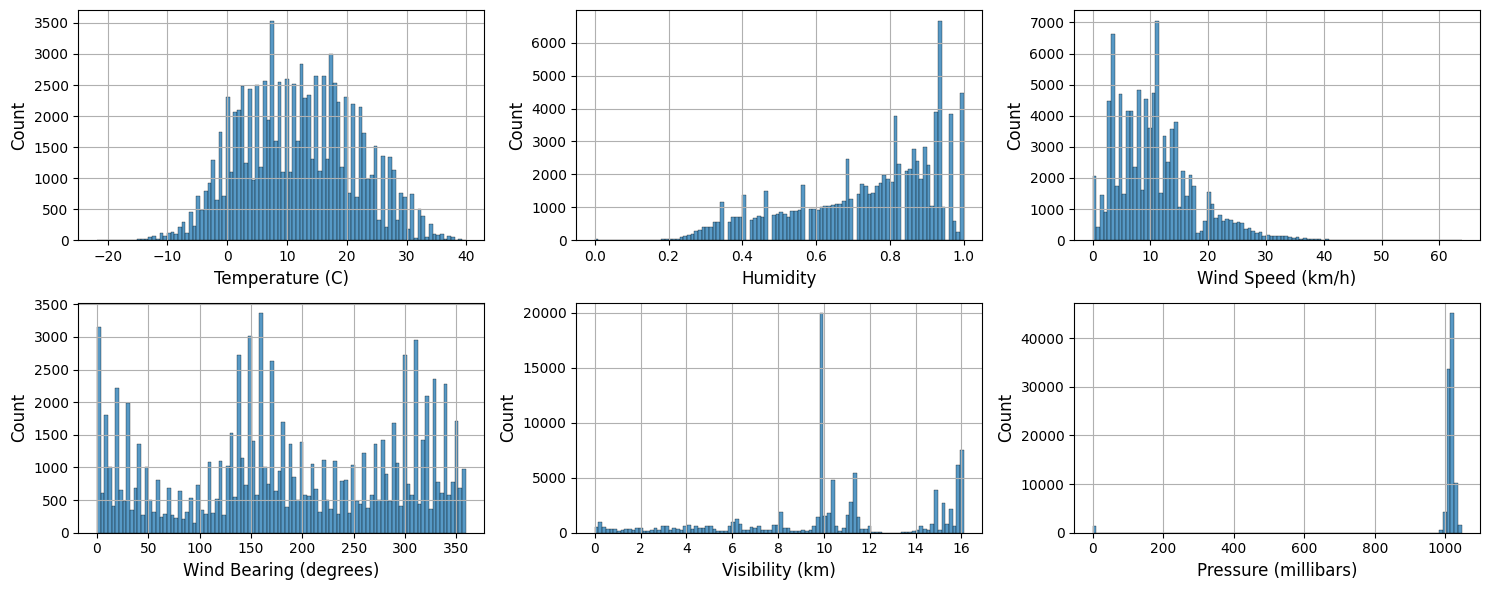

In [12]:
num_cols = [ 'Temperature (C)', 'Humidity', 'Wind Speed (km/h)',
       'Wind Bearing (degrees)', 'Visibility (km)','Pressure (millibars)']

fig, axes = plt.subplots(2,3)
axes = axes.ravel()
for count, col in enumerate(num_cols):
  ax = axes[count]
  ax.grid()
  sns.histplot(data_df, x=col, ax=ax, bins=100)
plt.tight_layout()

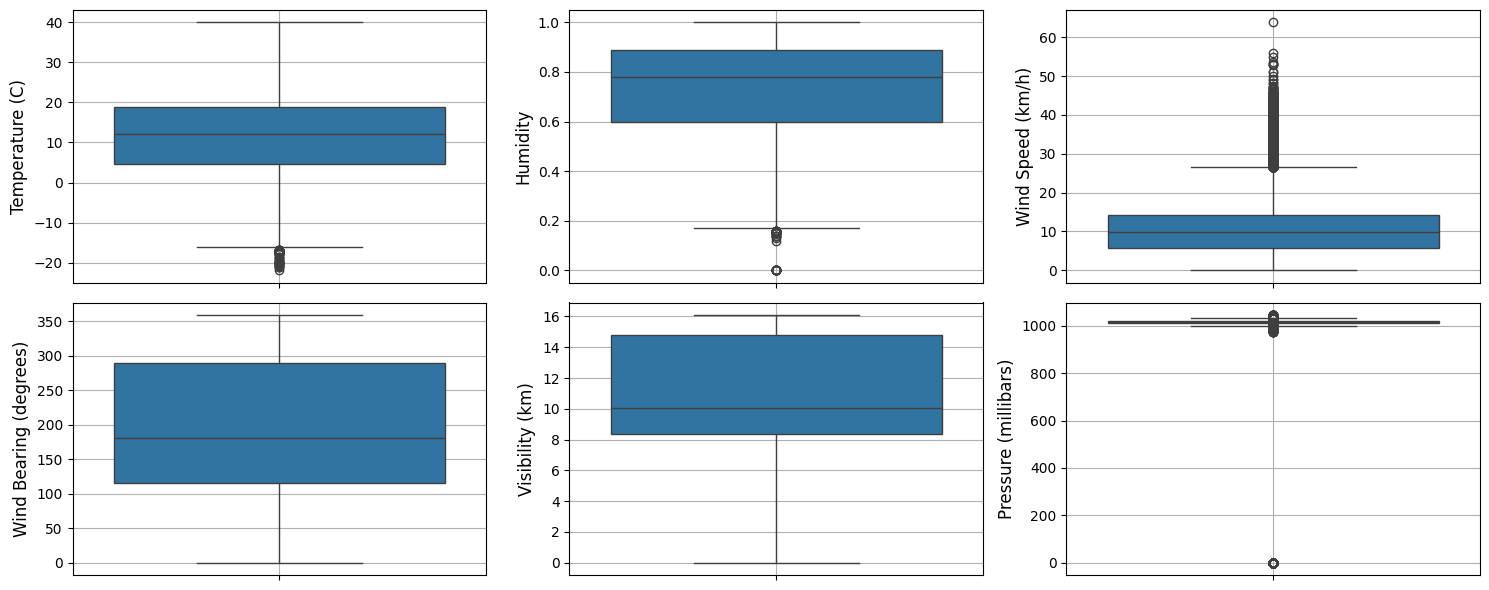

In [13]:
fig, axes = plt.subplots(2,3)
axes = axes.ravel()
for count, col in enumerate(num_cols):
  ax = axes[count]
  sns.boxplot(data=data_df, y=col, ax=ax)
  ax.grid()
plt.tight_layout()

<Axes: >

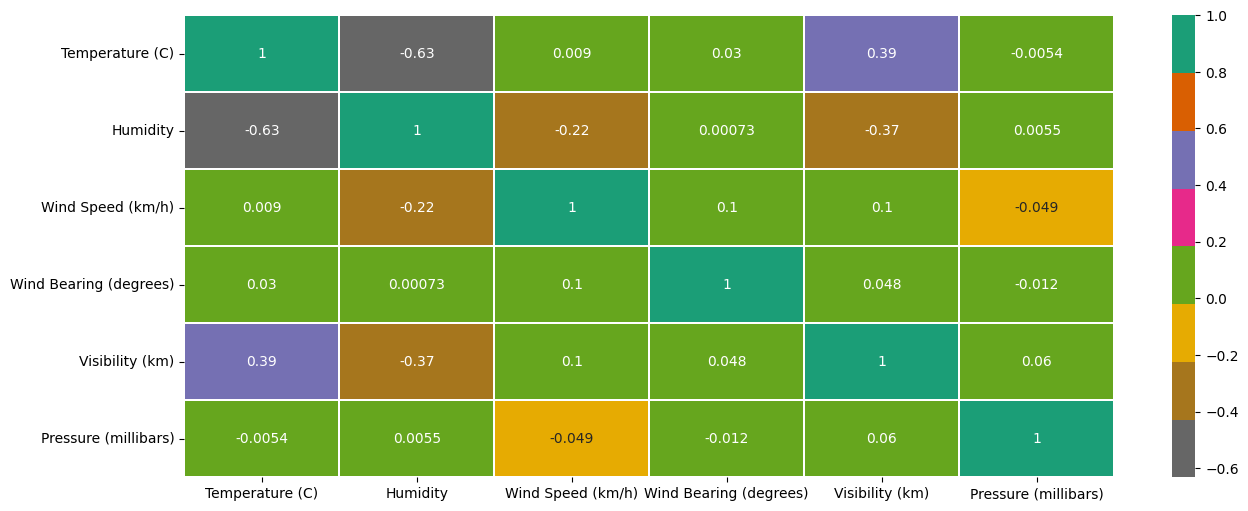

In [14]:
sns.heatmap(data_df[num_cols].corr(), annot=True, cmap='Dark2_r', linewidths=0.2)

In [15]:
temp_df = data_df[['datetime', 'Temperature (C)']]          # temperature_df
temp_df = temp_df.sort_values('datetime', axis=0, ascending=True)
temp_df = temp_df.reset_index(drop=True)
temp_df = temp_df.rename({ 'Temperature (C)' : 'temp'}, axis=1)
temp_df.head()

,datetime,temp
0,2005-12-31 23:00:00+00:00,0.577778
1,2006-01-01 00:00:00+00:00,1.161111
2,2006-01-01 01:00:00+00:00,1.666667
3,2006-01-01 02:00:00+00:00,1.711111
4,2006-01-01 03:00:00+00:00,1.183333


In [16]:
temp_df.shape

(96453, 2)

In [17]:
h_units = 100       # hidden units
input_shape = (1, 10000)
initializer = tf.keras.initializers.GlorotUniform(seed=RANDOM_STATE)
optimizer = tf.keras.optimizers.Adam(learning_rate=ALPHA)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
activation = 'tanh'

model = tf.keras.Sequential([
    tf.keras.Input(shape=input_shape),
    tf.keras.layers.SimpleRNN(units = h_units, activation = activation),

    tf.keras.layers.Dense(1, activation='linear', kernel_initializer= initializer)  # Output Layer
])

In [18]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 100)            │     1,010,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,010,201 (3.85 MB)

 Trainable params: 1,010,201 (3.85 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
wax = model.get_weights()[0]
waa = model.get_weights()[1]
baa = model.get_weights()[2]
way = model.get_weights()[3]
bay = model.get_weights()[4]

wax.shape, waa.shape, baa.shape , way.shape, bay.shape

((10000, 100), (100, 100), (100,), (100, 1), (1,))

In [20]:
del model

temp_df

,datetime,temp
0,2005-12-31 23:00:00+00:00,0.577778
1,2006-01-01 00:00:00+00:00,1.161111
2,2006-01-01 01:00:00+00:00,1.666667
3,2006-01-01 02:00:00+00:00,1.711111
4,2006-01-01 03:00:00+00:00,1.183333
...,...,...
96448,2016-12-31 18:00:00+00:00,0.488889
96449,2016-12-31 19:00:00+00:00,0.072222
96450,2016-12-31 20:00:00+00:00,-0.233333
96451,2016-12-31 21:00:00+00:00,-0.472222


In [21]:
temp_df.head(25)                   # this data is hourly data so we need to convert 24 hrs to make a day and make next day's prediction based on this

,datetime,temp
0,2005-12-31 23:00:00+00:00,0.577778
1,2006-01-01 00:00:00+00:00,1.161111
2,2006-01-01 01:00:00+00:00,1.666667
3,2006-01-01 02:00:00+00:00,1.711111
4,2006-01-01 03:00:00+00:00,1.183333
5,2006-01-01 04:00:00+00:00,1.205556
6,2006-01-01 05:00:00+00:00,2.222222
7,2006-01-01 06:00:00+00:00,2.072222
8,2006-01-01 07:00:00+00:00,2.200000
9,2006-01-01 08:00:00+00:00,2.733333


In [22]:
time_step = 24

y_idx = np.arange(time_step, temp_df.shape[0], time_step)
y_df = temp_df.iloc[y_idx]                                           # here we get index or values after 24 hours
y_df.head()

,datetime,temp
24,2006-01-01 23:00:00+00:00,5.422222
48,2006-01-02 23:00:00+00:00,1.694444
72,2006-01-03 23:00:00+00:00,2.200000
96,2006-01-04 23:00:00+00:00,1.666667
120,2006-01-05 23:00:00+00:00,1.805556


In [23]:
y_df.tail()        # tail data won't match our head as the last value doesn't complete or fall into 24 hours block

,datetime,temp
96336,2016-12-27 02:00:00+00:00,-1.627778
96360,2016-12-28 02:00:00+00:00,-1.677778
96384,2016-12-29 02:00:00+00:00,-1.727778
96408,2016-12-30 02:00:00+00:00,-1.777778
96432,2016-12-31 02:00:00+00:00,-1.822222


In [24]:
temp_df.tail()

,datetime,temp
96448,2016-12-31 18:00:00+00:00,0.488889
96449,2016-12-31 19:00:00+00:00,0.072222
96450,2016-12-31 20:00:00+00:00,-0.233333
96451,2016-12-31 21:00:00+00:00,-0.472222
96452,2016-12-31 22:00:00+00:00,-0.677778


In [25]:
temp_df.shape , y_df.shape[0]*time_step                   # here both these numbers didn't match hence we create a new df i.e. X_df

((96453, 2), 96432)

In [26]:
X_df = temp_df.iloc[range(len(y_df)*time_step)]
X_df.shape                                            # now the shape of X_df matches with that of the shape of y_df.shape[0]*time_step

(96432, 2)

In [27]:
X = np.reshape(X_df['temp'].values, (y_df.shape[0], time_step))             # np bcoz we don't X to be a dataframe
X = X[:, :23]                                                               # here it gets all the 24 values so we drop the last col and takes only till col 23
X.shape

(4018, 23)

In [28]:
# now to put the X in such a way that the layers can accept the shape that the layers expect as an input
X = np.reshape(X, (X.shape[0], X.shape[1], 1))
X.shape

(4018, 23, 1)

In [29]:
# Now the below is the overall split of out data
split = int(y_df.shape[0]*(1-TEST_SIZE))
split
X_train = X[:split]
X_test = X[split:]
y_train = y_df['temp'].values[:split]
y_test = y_df['temp'].values[split:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape



((3214, 23, 1), (804, 23, 1), (3214,), (804,))

### MODEL

This model takes the input as a list.

In [30]:
h_units = 256       # hidden units
input_shape = (time_step-1, 1)
initializer = tf.keras.initializers.GlorotUniform(seed=RANDOM_STATE)
optimizer = tf.keras.optimizers.Adam(learning_rate=ALPHA)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
activation = 'tanh'

model = tf.keras.Sequential([
    tf.keras.Input(shape=input_shape),
    tf.keras.layers.SimpleRNN(units = h_units, activation = activation),

    tf.keras.layers.Dense(1, activation='linear', kernel_initializer= initializer)  # Output Layer
])

model.compile(loss = 'mean_squared_error',
              optimizer = optimizer,
              metrics= [tf.keras.metrics.RootMeanSquaredError()])

In [31]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_1 (SimpleRNN)        │ (None, 256)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,305 (259.00 KB)

 Trainable params: 66,305 (259.00 KB)

 Non-trainable params: 0 (0.00 B)

In [32]:
history = model.fit(X_train, y_train, validation_data=[X_test, y_test], epochs = EPOCHS, batch_size=BATCH_SIZE, verbose=2)

Epoch 1/30
101/101 - 6s - 55ms/step - loss: 7.7070 - root_mean_squared_error: 2.7762 - val_loss: 0.9608 - val_root_mean_squared_error: 0.9802
Epoch 2/30
101/101 - 4s - 39ms/step - loss: 1.4952 - root_mean_squared_error: 1.2228 - val_loss: 0.9986 - val_root_mean_squared_error: 0.9993
Epoch 3/30
101/101 - 2s - 21ms/step - loss: 1.3061 - root_mean_squared_error: 1.1428 - val_loss: 0.9647 - val_root_mean_squared_error: 0.9822
Epoch 4/30
101/101 - 3s - 33ms/step - loss: 1.1683 - root_mean_squared_error: 1.0809 - val_loss: 0.7581 - val_root_mean_squared_error: 0.8707
Epoch 5/30
101/101 - 7s - 71ms/step - loss: 1.1431 - root_mean_squared_error: 1.0692 - val_loss: 0.7128 - val_root_mean_squared_error: 0.8443
Epoch 6/30
101/101 - 5s - 49ms/step - loss: 1.1076 - root_mean_squared_error: 1.0524 - val_loss: 0.6779 - val_root_mean_squared_error: 0.8233
Epoch 7/30
101/101 - 4s - 36ms/step - loss: 1.1035 - root_mean_squared_error: 1.0505 - val_loss: 0.7301 - val_root_mean_squared_error: 0.8545
Epoch 

In [33]:
loss_df = pd.DataFrame(history.history)
loss_df = loss_df.rename({'root_mean_squared_error' : 'rmse', 'val_root_mean_squared_error': 'val_rmse'}, axis=1)
loss_df.head()

,loss,rmse,val_loss,val_rmse
0,7.707019,2.776152,0.960823,0.980216
1,1.495237,1.222799,0.998635,0.999317
2,1.306075,1.142837,0.964656,0.982169
3,1.168347,1.080901,0.758105,0.870692
4,1.143108,1.069162,0.712835,0.844296


In [34]:
loss_df.columns

Index(['loss', 'rmse', 'val_loss', 'val_rmse'], dtype='object')

In [35]:
def fn_plot_tf_hist(hist_df):

    fig, axes = plt.subplots(1,2, figsize=(15,5))

    y1 = hist_df.columns[0]
    y2 = hist_df.columns[1]
    y3 = hist_df.columns[2]
    y4 = hist_df.columns[3]

    best = hist_df[hist_df[y4] == hist_df[y4].min()]
    # print(best)

    props = dict(boxstyle = 'round', facecolor = 'aqua', alpha = 0.4)
    facecolor = 'cyan'
    fontsize = 12
    CMAP = plt.cm.coolwarm
    ax = axes[0]

    hist_df.plot(y=[y2,y4], ax=ax, colormap = CMAP)
    txtFmt = 'Loss : \n   train : {:6.4f}\n     test : {:6.4f}'
    txtstr = txtFmt.format(hist_df.iloc[-1][y2].min(), hist_df.iloc[-1][y4])


    ax.text(0.3, 0.95, txtstr, transform=ax.transAxes, fontsize=fontsize, verticalalignment='top', bbox = props)

    # Offset for the Arrows
    y_min = min(hist_df[y2].min(), hist_df[y4].min())
    y_max = max(hist_df[y2].max(), hist_df[y4].max())
    offset = (y_max - y_min)/10.0

    ax.annotate(f'Min : {best[y4].to_numpy()[0]:6.4}',    # text to print
                xy = (best.index.to_numpy()[0], best[y4].to_numpy()[0]),  # start
                xytext = (best.index.to_numpy()[0], best[y4].to_numpy()[0] + offset),   #end
                fontsize = fontsize, va='bottom', ha = 'right', bbox= props,
                arrowprops = dict(facecolor = facecolor, shrink = 0.05))

    ax.axvline(best.index.to_numpy()[0], color = 'g', linestyle = '-.', lw = 3)
    ax.set_xlabel('Epochs')
    ax.set_ylabel(y2.capitalize())

    ax.grid()


    ax = axes[1]
    hist_df.plot(y=[y1,y3], ax=ax, colormap = CMAP)
    txtFmt = 'Loss : \n   train : {:6.4f}\n     test : {:6.4f}'
    txtstr = txtFmt.format(hist_df.iloc[-1][y1], hist_df.iloc[-1][y3])

    ax.text(0.3, 0.2, txtstr, transform=ax.transAxes, fontsize=fontsize, verticalalignment='top', bbox = props)

    # Offset for the Arrows
    y_min = min(hist_df[y1].min(), hist_df[y3].min())
    y_max = max(hist_df[y1].max(), hist_df[y3].max())
    offset = (y_max - y_min)/10.0

    ax.annotate(f'Best : {best[y3].to_numpy()[0]:6.4}',    # text to print
                xy = (best.index.to_numpy(), best[y3].to_numpy()[0]),  # start
                xytext = (best.index.to_numpy(), best[y3].to_numpy()[0] + offset),
                fontsize = fontsize, va='bottom', ha = 'right', bbox= props,
                arrowprops = dict(facecolor = facecolor, shrink = 0.05))

    ax.axvline(best.index.to_numpy(), color = 'g', linestyle = '-.', lw = 3)
    ax.set_xlabel('Epochs')
    ax.set_ylabel(y1.capitalize())

    ax.grid()
    plt.suptitle('Training Perfromance')
    plt.tight_layout()
    plt.show()
    # ax = axes[1]
    # hist_df.plot(y=[y2,y4], ax=axes[0])
    # hist_df.plot(y=[y1,y3], ax=ax)

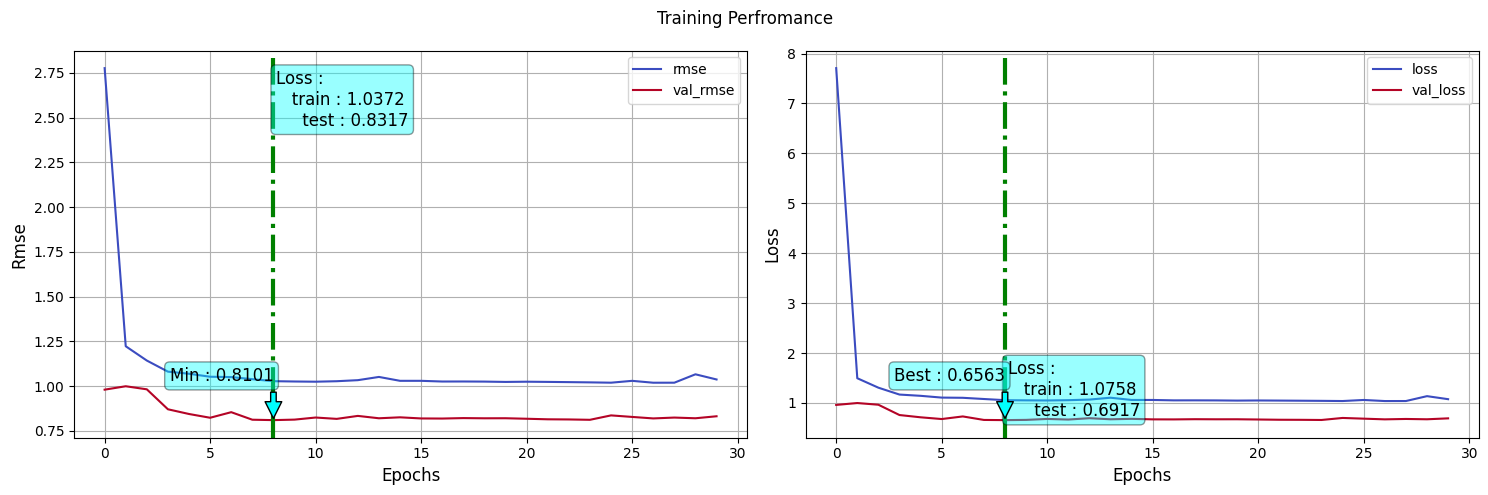

In [36]:
fn_plot_tf_hist(loss_df)

In [37]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
y_pred = np.append(y_train_pred, y_test_pred)
y_pred.shape

101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


(4018,)

In [38]:
res_df = y_df.copy()
res_df['pred'] = y_pred
res_df['datetime'] = res_df['datetime'].dt.date
res_df.head()

,datetime,temp,pred
24,2006-01-01,5.422222,4.732885
48,2006-01-02,1.694444,1.880844
72,2006-01-03,2.200000,1.976496
96,2006-01-04,1.666667,1.888142
120,2006-01-05,1.805556,2.519074


In [39]:
res_df.tail()

,datetime,temp,pred
96336,2016-12-27,-1.627778,-1.462246
96360,2016-12-28,-1.677778,-1.510325
96384,2016-12-29,-1.727778,-1.557556
96408,2016-12-30,-1.777778,-1.604762
96432,2016-12-31,-1.822222,-1.647022


<Axes: xlabel='datetime'>

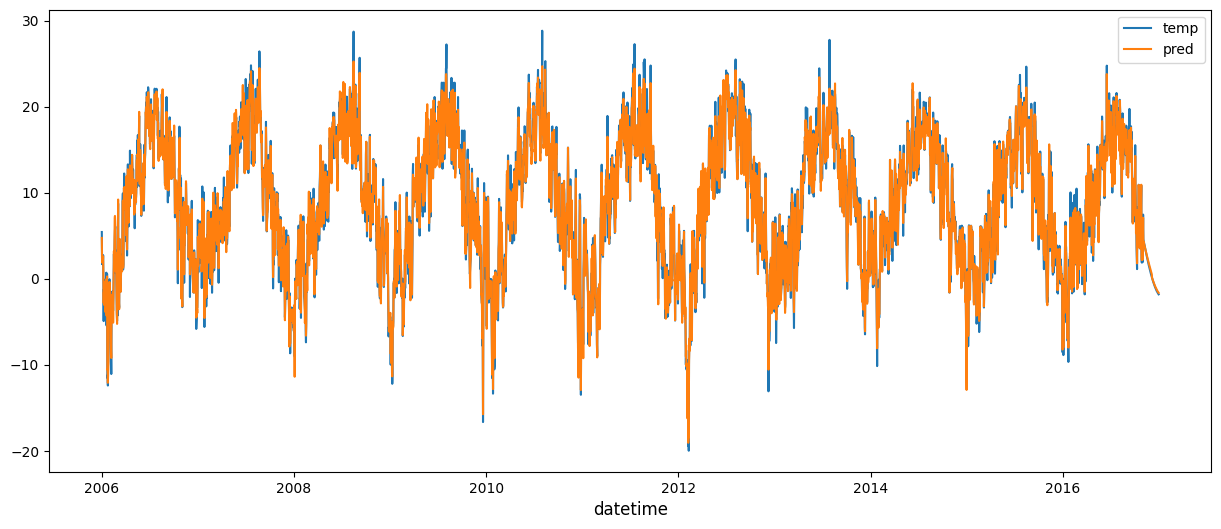

In [40]:
res_df.plot(x = 'datetime', y = ['temp', 'pred'])

<Axes: xlabel='datetime'>

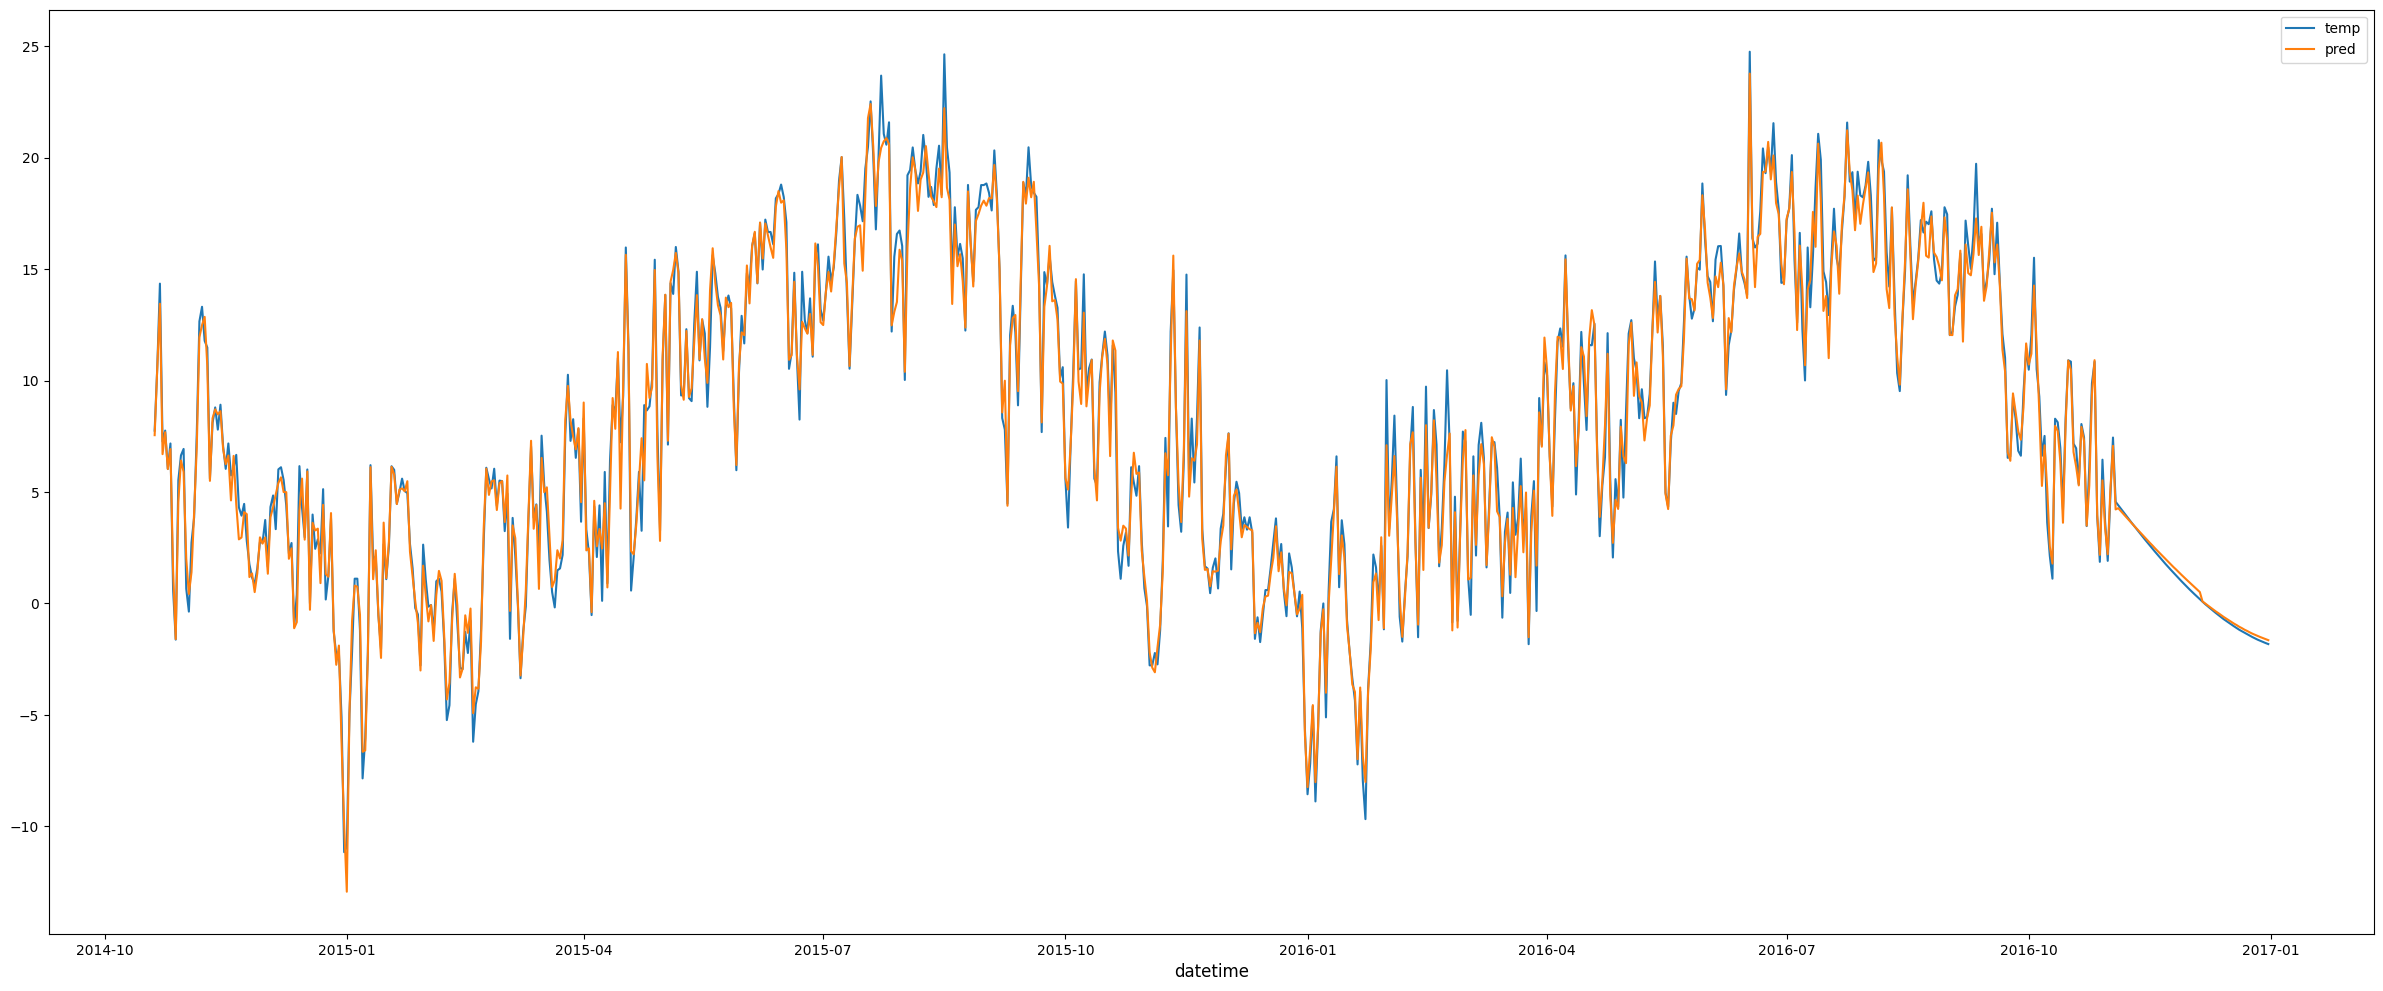

In [41]:
fig, ax = plt.subplots(figsize = (30,12))

res_df.iloc[X_train.shape[0]:].plot(x = 'datetime', y = ['temp', 'pred'], ax= ax)